## Reviewer comment:
Data analysis and use of "magratio" as measure of effect size.
1. It would be great to see a distribution of signal for many replicates of positive and negative controls to get a clearer understanding of the assay robustness.
2. The statistical analysis of the data appears to be rigorous and built in normalization appears to be critical for detection inhibition with good fidelity. It would be useful if the authors could include an analysis using the z-prime metric, which is the standard effect size measure for high throughput screening. This may help readers relate the robustness of this approach to other screens. Alternatively, the authors may want to include a further justification for the use of their magratio metric.
4. Also, there are additional factors that may be useful to include in the discussion of their data analysis:
    * Do they observe heteroskedasity in their data variance?
    * Would a log transformation be appropriate?
    * How much sequencing depth per compound per strain is required to get adequate sampling? This would indicate how much multiplexing capacity is possible with this approach and current DNA sequencing capabilities.

In [1]:
import os

from collections import OrderedDict

import numpy as np

import pandas as pd

from scipy.stats import wilcoxon

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from platelayout import PlateLayout


sns.set_context("paper", font_scale=1.5)

style="whitegrid"
rc={"font.name"      : "Arial",
    "axes.facecolor" : "0.99",
    "grid.color"     : "0.95",
    "axes.edgecolor" : "0.90"}


datadir   = "data"
countsdir = os.path.join(datadir, "counts")
oddir     = os.path.join(datadir, "od")
df = list()
for run in os.listdir(countsdir):
    rundir = os.path.join(countsdir, run)
    for fp in os.listdir(rundir):
        df.append(pd.read_csv(os.path.join(rundir,fp)))
        df[-1].insert(0, "run", run)
        df[-1].insert(1, "plate", '_'.join(fp[:-4].split('_')[:-1]))
df = pd.concat(df, ignore_index=True)
df.well = df.well.apply(
    lambda x: "{}{:02d}".format(x[0],int(x[1:])) if all(c.isdigit() for c in x[1:]) else x)

od = list()
for fp in os.listdir(oddir):
    od.append(pd.read_csv(os.path.join(oddir, fp)))
    od[-1].insert(0, "run", fp[:-4])
od = pd.concat(od, ignore_index=True)

df["layout"] = df.plate.apply(PlateLayout)

wellsums = df.groupby(["runid","plate","well"]).counts.sum()
df["wellsum"]  = df.apply(lambda row: wellsums[row.runid, row.plate, row.well], axis=1)
df["nrmcount"] = df.counts / df.wellsum

df["ctrlgene"] = None
df["ctrlwell"] = None
df["poswellposctrl"] = False
df["poswellnegctrl"] = False
df["negwellposctrl"] = False
df["negwellnegctrl"] = False
for rowidx,row in df.iterrows():
    poswell = (row.well in row.layout.getLopCtrl())
    negwell = (row.well in row.layout.getNegCtrl())
    posctrl = (row.gene in ["HIV-1","HIV-2"])
    negctrl = (row.gene == "EYFP")
    df.loc[rowidx,"poswellposctrl"] = (poswell and posctrl)
    df.loc[rowidx,"poswellnegctrl"] = (poswell and negctrl)
    df.loc[rowidx,"negwellposctrl"] = (negwell and posctrl)
    df.loc[rowidx,"negwellnegctrl"] = (negwell and negctrl)
    if poswell or negwell:
        df.loc[rowidx, "ctrlwell"] = "Lopinavir" if poswell else "DMSO"
    if posctrl or negctrl:
        df.loc[rowidx, "ctrlgene"] = "HIV" if posctrl else "EYFP"

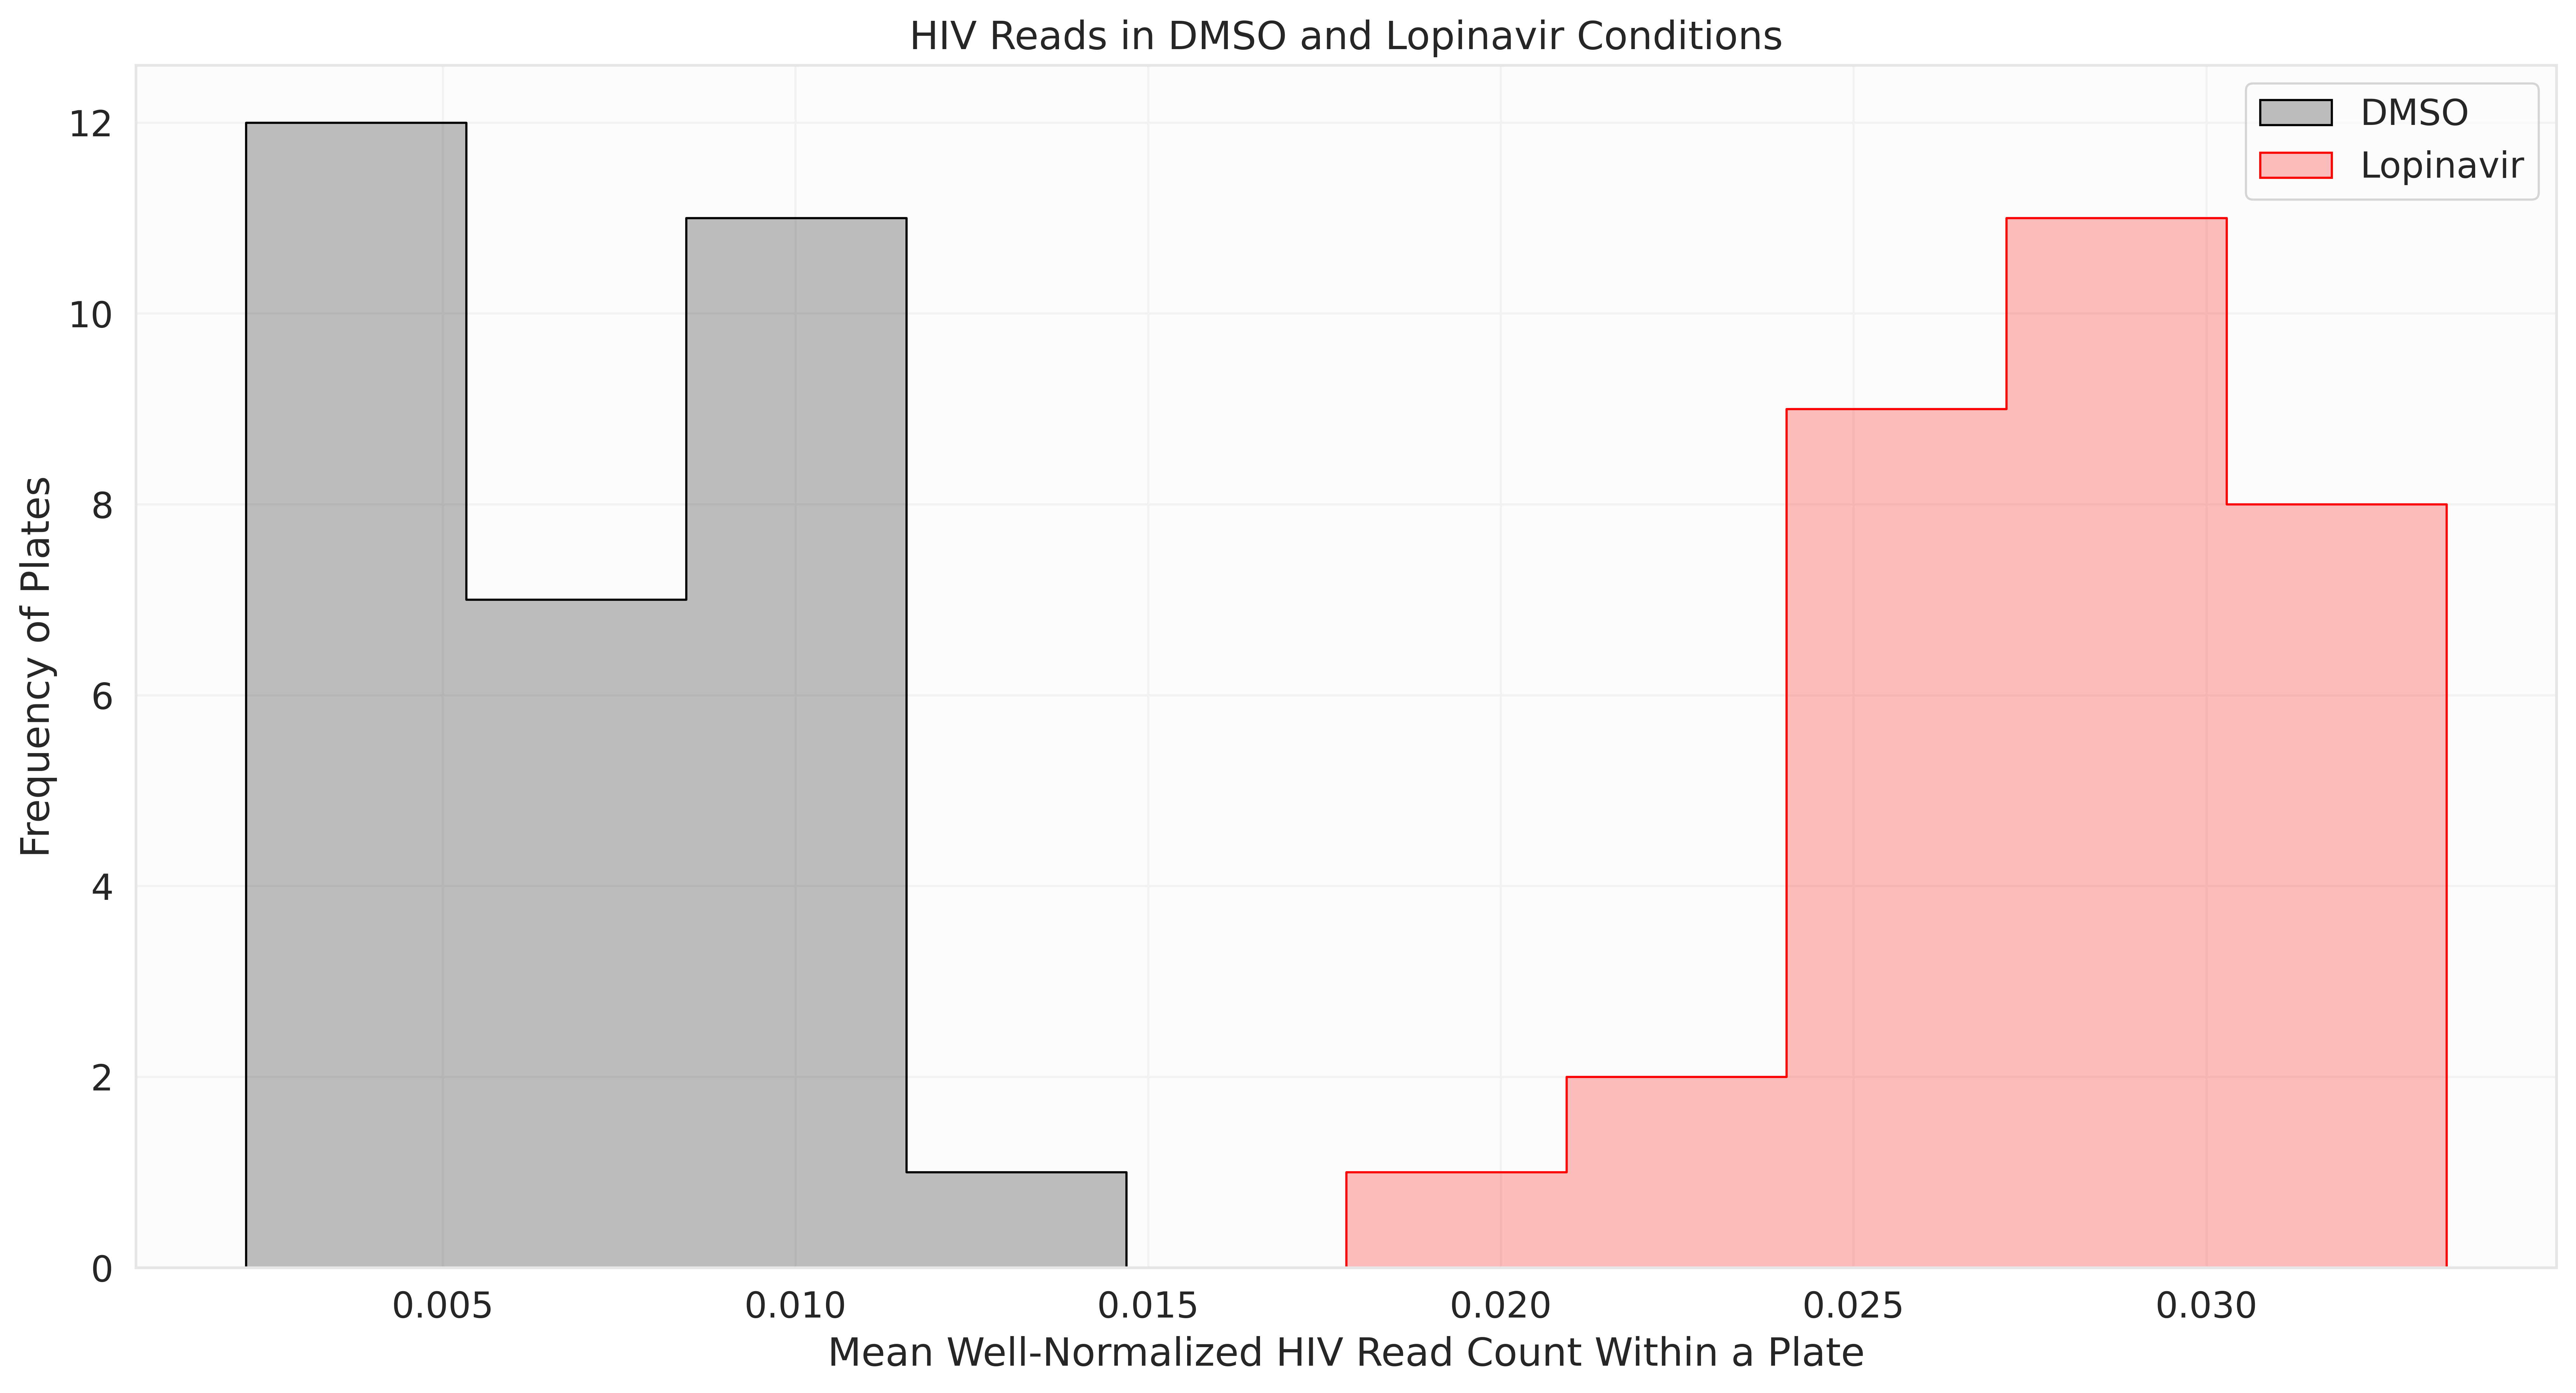

In [2]:
def _plothist(ax, mask, title, legend, hue):
    sns.histplot(
        ax        = ax,
        data      = df[mask].groupby(["run","plate",hue]).nrmcount.mean().reset_index(),
        hue       = hue,
        x         = "nrmcount",
        bins      = 25 if (hue == "ctrlgene") else 10, # more bins for more data
        hue_order = ["DMSO","Lopinavir"] if (hue=="ctrlwell") else ["EYFP","HIV"],
        palette   = ["black", "red"],
        element   = "step")
    ax.get_legend().set_title(legend)
    ax.set_xlabel("Mean Well-Normalized HIV Read Count Within a Plate")
    ax.set_ylabel("Frequency of Plates")
    ax.set_title(title)

with sns.axes_style(style=style, rc=rc):
    fig, ax = plt.subplots(figsize=(16,8), dpi=600)
    _plothist(
        ax     = ax,
        mask   = df.poswellposctrl | df.negwellposctrl,
        title  = "HIV Reads in DMSO and Lopinavir Conditions",
        legend = None,
        hue    = "ctrlwell")

In [3]:
def _printZprime(df, countscol):
    posmean = df[df.poswellposctrl].groupby(["run","plate"])[countscol].mean().mean()
    posstd  = df[df.poswellposctrl].groupby(["run","plate"])[countscol].mean().std()
    negmean = df[df.negwellposctrl].groupby(["run","plate"])[countscol].mean().mean()
    negstd  = df[df.negwellposctrl].groupby(["run","plate"])[countscol].mean().std()
    zprime = 1 - ( 3*(posstd + negstd) / abs(posmean - negmean) )
    print('-'*80)
    print("counts column: {}".format(countscol))
    print("\tposmean {:0.4f}".format(posmean))
    print("\tposstd  {:0.4f}".format(posstd ))
    print("\tnegmean {:0.4f}".format(negmean))
    print("\tnegstd  {:0.4f}".format(negstd ))
    print("\tz-prime {:0.4f}".format(zprime ))


# pseudocount to prevent division by -inf
df["logcounts"] = (df.counts + 1).apply(np.log10)
logwellsums = df.groupby(["runid","plate","well"]).logcounts.sum()
df["logwellsum"]  = df.apply(lambda row: logwellsums[row.runid, row.plate, row.well], axis=1)
df["lognrmcount"] = df.logcounts / df.logwellsum

_printZprime(df, "counts")
_printZprime(df, "nrmcount")
_printZprime(df, "logcounts")
_printZprime(df, "lognrmcount")

--------------------------------------------------------------------------------
counts column: counts
	posmean 6483.8613
	posstd  2863.3972
	negmean 1624.6988
	negstd  1036.9164
	z-prime -1.4080
--------------------------------------------------------------------------------
counts column: nrmcount
	posmean 0.0282
	posstd  0.0035
	negmean 0.0067
	negstd  0.0030
	z-prime 0.0908
--------------------------------------------------------------------------------
counts column: logcounts
	posmean 3.7596
	posstd  0.1651
	negmean 3.0654
	negstd  0.2971
	z-prime -0.9975
--------------------------------------------------------------------------------
counts column: lognrmcount
	posmean 0.0066
	posstd  0.0003
	negmean 0.0053
	negstd  0.0004
	z-prime -0.5234


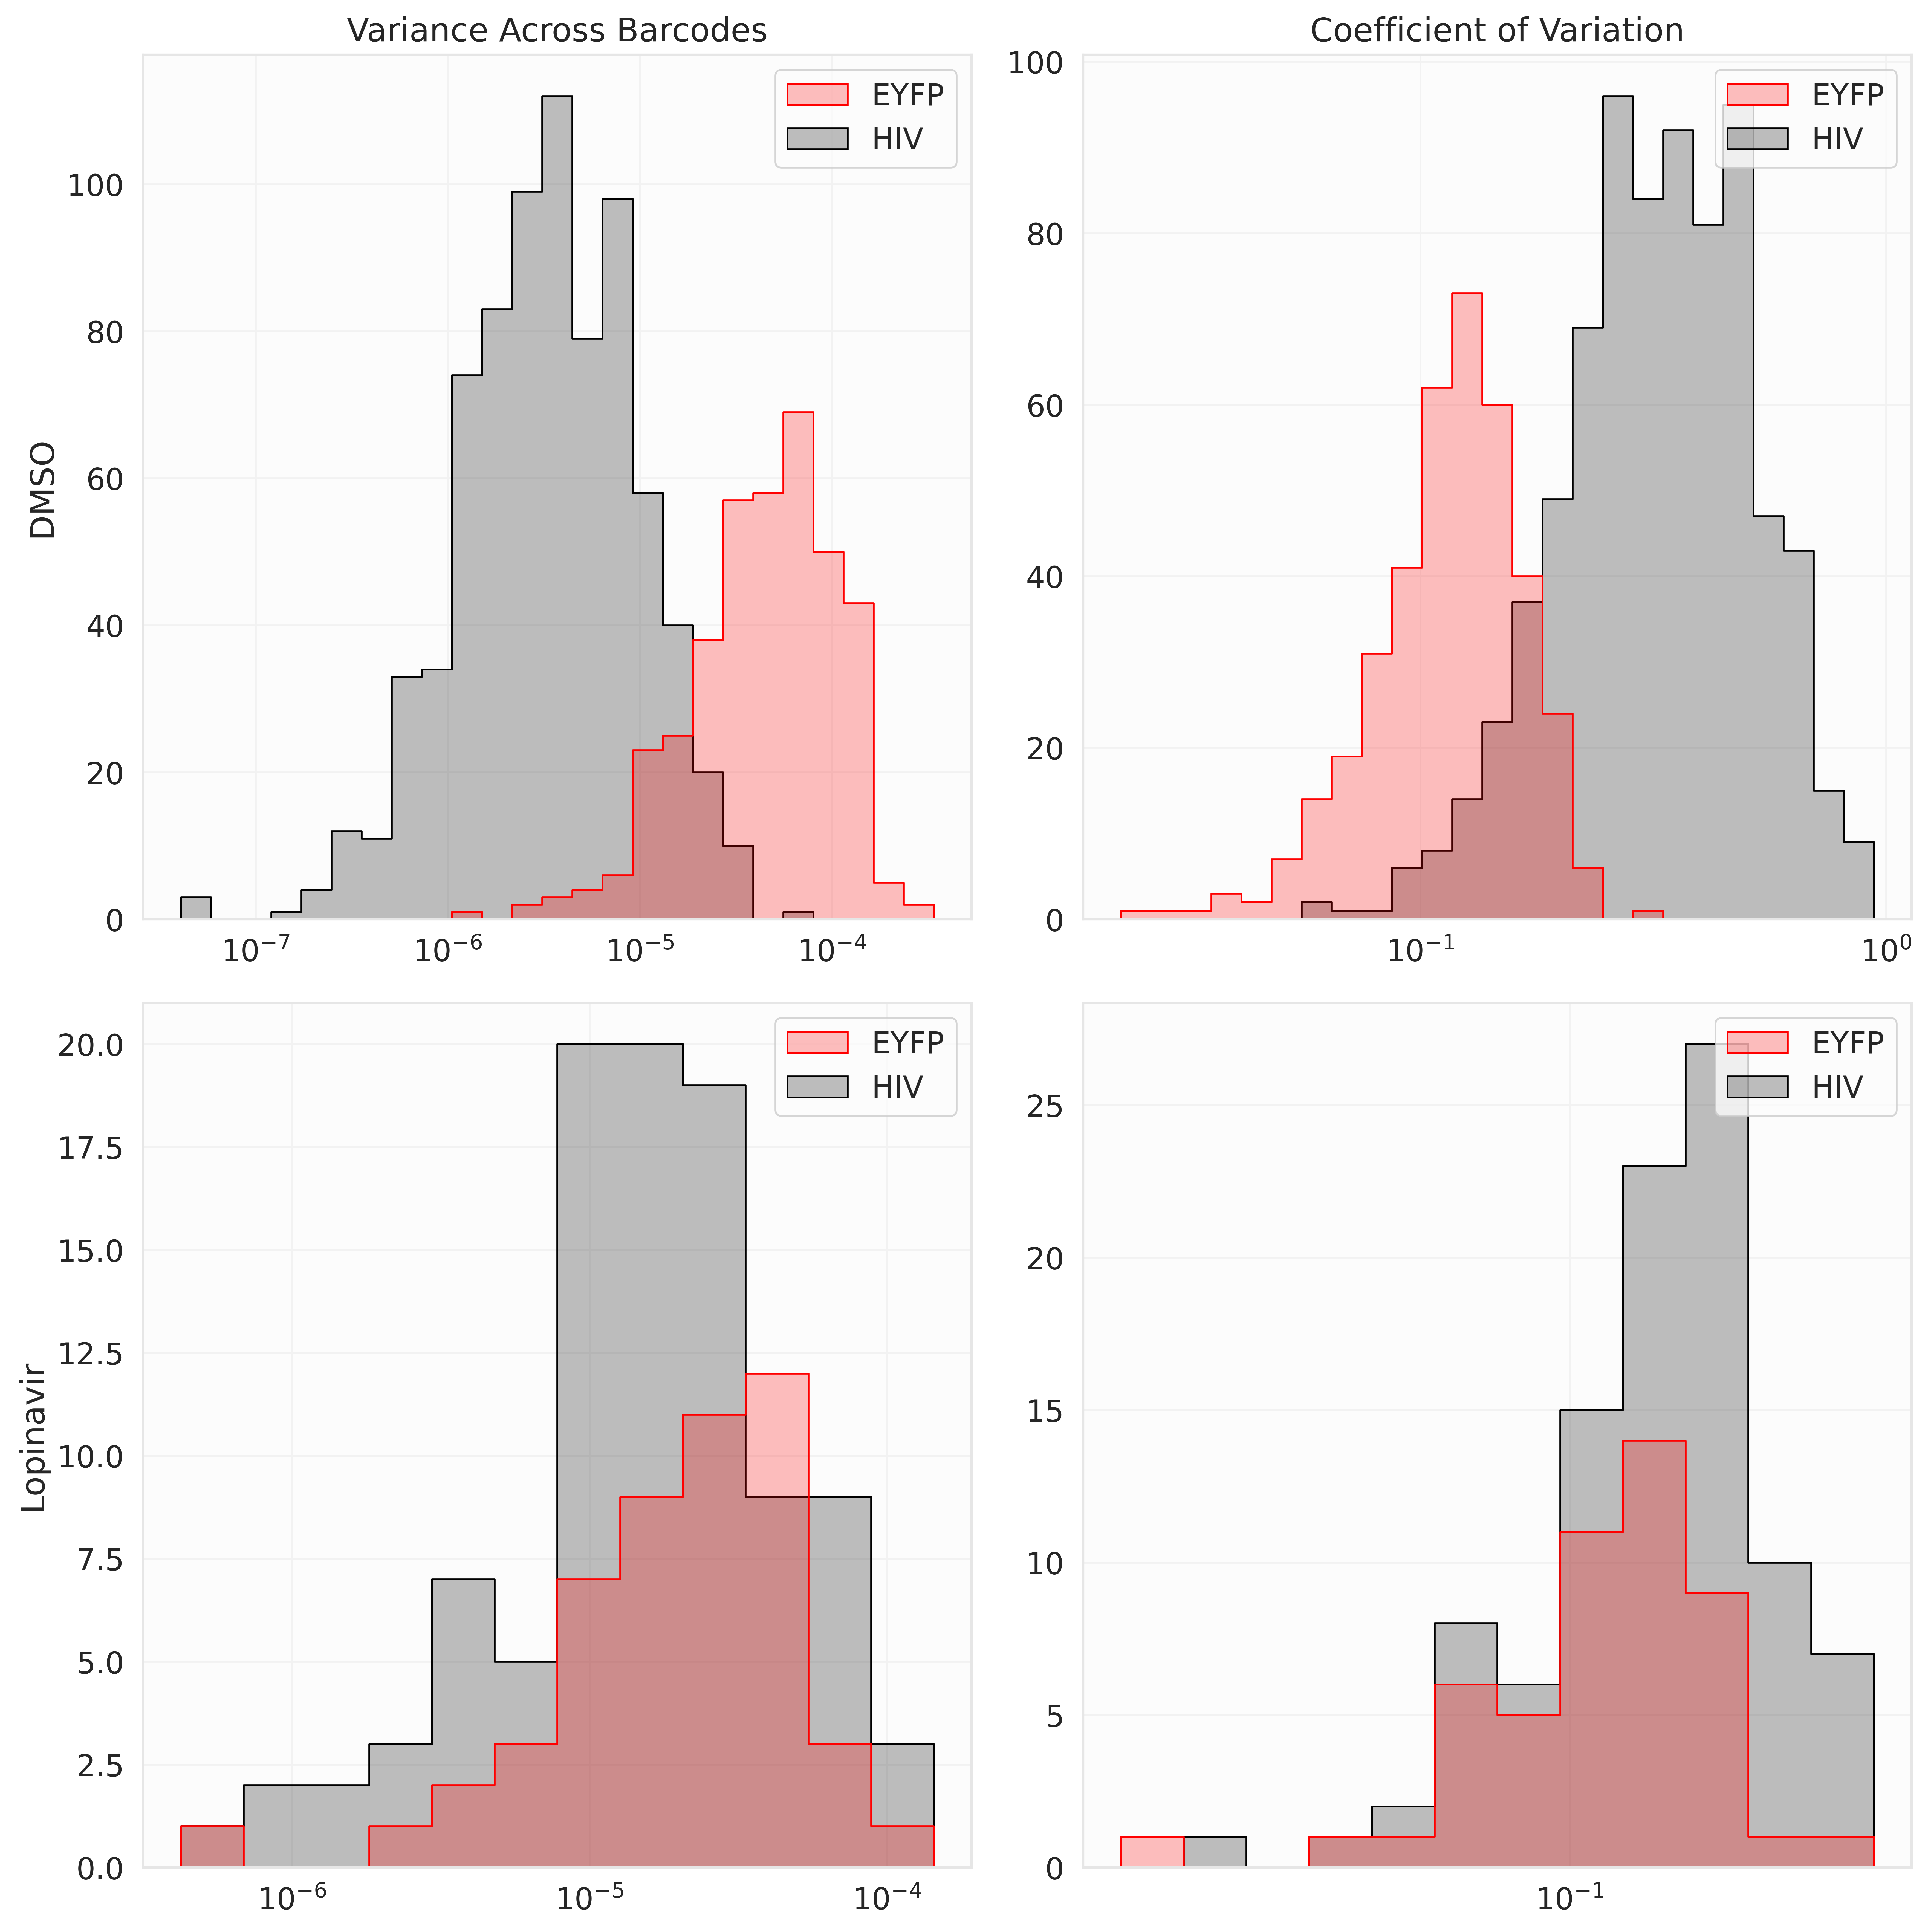

In [4]:
def _getbarcodecv(mask):
    subdf = df[mask]
    grp = ["run","plate","well","gene","ctrlgene"]
    cvdf  = subdf.groupby(grp).nrmcount.apply(
        lambda x: [np.std(x) / np.mean(x), np.var(x)]).reset_index()
    return pd.concat(
        [cvdf.drop("nrmcount", axis=1),
         cvdf.nrmcount.apply(pd.Series).rename(
             {0:"bccv", 1:"bcvar"},axis=1)],
        axis=1)


nngrp = _getbarcodecv(df.negwellnegctrl)
npgrp = _getbarcodecv(df.negwellposctrl)
pngrp = _getbarcodecv(df.poswellnegctrl)
ppgrp = _getbarcodecv(df.poswellposctrl)

nvar  = pd.concat([nngrp,npgrp])
pvar  = pd.concat([ppgrp,pngrp])

with sns.axes_style(style=style, rc=rc):
    fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, dpi=600)
    for row,(vardf,well) in enumerate(zip([nvar,pvar],["DMSO","Lopinavir"])):
        for col,(metric,title) in enumerate(zip(["bcvar","bccv"],["Variance Across Barcodes","Coefficient of Variation"])):
            ax = axes[row][col]
            sns.histplot(
                ax   = ax,
                data = vardf,
                x    = metric,
                hue  = "ctrlgene",
                hue_order = ["EYFP","HIV"],
                palette = ["red","black"],
                element = "step",
                bins = 25 if (row==0) else 12, # more bins for more DMSO wells
                log_scale=True)
            ax.get_legend().set_title(None)
            ax.set_xlabel(None)
            if row == 0:
                ax.set_title(title)
            if col == 0:
                ax.set_ylabel(well)
            else:
                ax.set_ylabel(None)
    plt.tight_layout()

In [5]:
cvthresh = 0.10
print("EYFP CV <= {} plate wells ({}) that are also in EYFP CV > {} plate wells ({})".format(
    cvthresh, (pvar.bccv.le(cvthresh) & pvar.gene.eq("EYFP")).sum(), cvthresh, (pvar.bccv.gt(cvthresh) & pvar.gene.eq("EYFP")).sum()))
for x in pvar[pvar.bccv.le(cvthresh) & pvar.gene.eq("EYFP")].plate.unique():
    print(x, pvar[pvar.bccv.gt(cvthresh) & pvar.gene.eq("EYFP")].plate.eq(x).sum())
print('-'*80)
print("HIV CV <= {} plate wells ({}) that are also in HIV CV > {} plate wells ({})".format(
    cvthresh, (pvar.bccv.le(cvthresh) & pvar.gene.ne("EYFP")).sum(), cvthresh, (pvar.bccv.gt(cvthresh) & pvar.gene.ne("EYFP")).sum()))
for x in pvar[pvar.bccv.le(cvthresh) & pvar.gene.ne("EYFP")].plate.unique():
    print(x, pvar[pvar.bccv.gt(cvthresh) & pvar.gene.ne("EYFP")].plate.eq(x).sum())

EYFP CV <= 0.1 plate wells (14) that are also in EYFP CV > 0.1 plate wells (36)
NCIDIV_4865 0
NCIDIV_4866 0
NCIDIV_4867 0
NCIDIV_4869 0
NCIDIV_4870 0
NCIDIV_4871 0
NCIDIV_4878 0
NS1519_22009 1
NS1519_22016 1
NS1519_22020 1
NS1519_22021 1
NS1519_22022 1
NS1519_22024 1
--------------------------------------------------------------------------------
HIV CV <= 0.1 plate wells (20) that are also in HIV CV > 0.1 plate wells (80)
NCIDIV_4862 0
NCIDIV_4864 1
NCIDIV_4865 1
NCIDIV_4869 1
NCIDIV_4870 1
NCIDIV_4871 1
NCIDIV_4860 3
NCIDIV_4873 2
NCIDIV_4874 3
NCIDIV_4877 3
NS1519_22009 2
NS1519_22010 2
NS1519_22016 3
NS1519_22017 2
NS1519_22022 3


In [6]:
def getModelDisplayNames():
    
    return OrderedDict([
    
    ("CCHFV"               , "CCHFV OTU"         ),  #  1
    ("DUGV"                , "DUGV OTU"          ),  #  2
    
    ("NWV"                 , "NWV 3CL"           ),  #  3
    ("SHV"                 , "SHV 3CL"           ),  #  4
    ("LV"                  , "LV 3CL"            ),  #  5
    
    ("Bat-SV-CoVZC45-3CL"  , "Bat-SL-CoVZC45 3CL"),  #  6
    ("SARS-CoV-2-3CL"      , "SARS-CoV-2 3CL"    ),  #  7
    ("SARS-CoV-1-3CL"      , "SARS-CoV 3CL"      ),  #  8
    ("Bat-CoV-HKU9-3CL"    , "Bat-CoV-HKU9 3CL"  ),  #  9
    ("HCoV-HKU1-3CL"       , "HCoV-HKU1 3CL"     ),  # 10
    ("HCoV-OC43-3CL"       , "HCoV-OC43 3CL"     ),  # 11
    ("Bat-CoV-HKU4-3CL"    , "Bat-CoV-HKU4 3CL"  ),  # 12
    ("MERS-CoV-3CL"        , "MERS-CoV 3CL"      ),  # 13
    ("HCoV-229E-3CL"       , "HCoV-229E 3CL"     ),  # 14
    ("HCoV-NL63-3CL"       , "HCoV-NL63 3CL"     ),  # 15
    ("Beluga-CoV-SW1"      , "BWCoV-SW1 3CL"     ),  # 16
    
    ("Bat-SL-CoVZC45-PLP2" , "Bat-SL-CoVZC45 PLP"),  # 17
    ("SARS-CoV-2-PLP"      , "SARS-CoV-2 PLP"    ),  # 18
    ("SARS-CoV-1-PLP"      , "SARS-CoV PLP"      ),  # 19
    ("MERS-CoV-PLP"        , "MERS-CoV PLP"      ),  # 20
    ("HCoV-NL63-PLP2"      , "HCoV-NL63 PLP2"    ),  # 21
    
    ("SLEV"                , "SLEV NS2B-GS-NS3"  ),  # 22
    ("KUNV"                , "KUNV NS2B-GS-NS3"  ),  # 23
    ("WNV"                 , "WNV NS2B-GS-NS3"   ),  # 24
    ("ZIKV"                , "ZIKV NS2B-GS-NS3"  ),  # 25
    ("DENV"                , "DENV NS3-GS-NS2B"  ),  # 26
    ("LGTV"                , "LGTV NS2B-GS-NS3"  ),  # 27
    ("POWV"                , "POWV NS2B-GS-NS3"  ),  
    ("HCV"                 , "HCV NS3-GS-NS4A"   ),  # 29
    
    ("PV"                  , "PV 3C"             ),  # 30
    ("CV-B3"               , "CV-B3 3C"          ),  # 31
    ("HRV-B14"             , "HRV-B14 3C"        ),  # 32
    ("EMCV"                , "EMCV 3C"           ),  # 33
    ("SV-A"                , "SV-A 3C"           ),  # 34
    ("HAV"                 , "HAV 3C"            ),  # 35
    ("HPeV"                , "HPeV 3C"           ),  # 36
    
    ("HTLV"                , "HTLV PR"           ),  # 37
    ("HIV-1"               , "HIV-1 PR"          ),  # 38
    ("HIV-2"               , "HIV-2 PR"          ),  # 39
    
    ("HHV-3"               , "HHV-3 PR"          ),  # 40
    
    ("YES1"                , "YES1"              ),  # 41
    ("c-Src"               , "c-Src"             ),  # 42
    ("FES"                 , "FES"               )]) # 43


def mapOD(df):
    od = list()
    for run in df.run.unique():
        od.append(pd.read_csv(
            os.path.join(oddir, "{}.csv".format(run))))
        od[-1].insert(0, "run", run)
    od = pd.concat(od)
    if len(od) != len(od.groupby(["run","plate","well"])):
        return ValueError("Duplicate run/plate/well tuple found in OD data")
    odmap = {(x.run,x.plate,x.well):x.OD595 for _,x in od.iterrows()}
    df["od"] = df.apply(lambda x: odmap[(x.run,x.plate,x.well)], axis=1)
    return df


def renameGenes(df):
    geneRenames = getModelDisplayNames()
    geneRenames.update({
        "DENV-NS3-GS-NS2B" : "DENV NS3-GS-NS2B",
        "HCV-NS3-GS-NS4A"  : "HCV NS3-GS-NS4A",
        "LGTV-NS2B-GS-NS3" : "LGTV NS2B-GS-NS3",
        "POWV-NS2B-GS-NS3" : "POWV NS2B-GS-NS3"})
    for gene in sorted(df.gene.unique()):
        if gene in geneRenames:
            continue
        if gene.split('-')[-1] in ["3C","3CL","PLP","PLP2","PR"]:
            geneRenames[gene] = \
                '-'.join(gene.split('-')[:-1]) + ' ' + gene.split('-')[-1]
        elif ' ' in gene:
            geneRenames[gene] = gene.replace(' ','-')
    df.gene = df.gene.apply(lambda x: geneRenames.get(x,x))
    
    return df

def readPlates():
    plates = pd.read_csv(os.path.join(datadir, "plates.csv"))
    plates.run = plates.run.astype(str)
    return plates


def readScores(hitsdir):
    plates = readPlates()
    df = list()
    for run in plates.run.unique():
        fp = os.path.join(hitsdir, "{}.csv".format(run))
        rundf = pd.read_csv(fp)
        rundf["run"] = run
        df.append(rundf)
    df = pd.concat(df)

    df = renameGenes(df)
    
    # Explicitly rename the below rows that do not have counts.
    # Plate NCIDIV_4867  has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    # Plate NCIDIV_4870  has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    # Plate NS1519_22024 has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    df.loc[(df.plate=="NCIDIV_4867")  & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    df.loc[(df.plate=="NCIDIV_4870")  & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    df.loc[(df.plate=="NS1519_22024") & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    
    df.well = df.well.apply(lambda x: "{}{:02d}".format(x[0],int(x[1:])))
    
    return df


def mapMagRatios(vals, scores):
    
    return vals.merge(
        scores,
        how = "left",
        on  = ["compoundsrc","compoundid","gene"])


def mapCompoundWells(df):
    df["compoundwell"] = df.apply(
        lambda row: PlateLayout(row.plate).getCompoundWell(row.well),
        axis=1)
    return df


def mapCompounds(df):
    compoundMap = pd.read_csv(
        os.path.join(datadir, "compound_map.csv"),
        dtype={"id" : str})
    if ("compoundsrc" in df.columns) and ("compoundid" in df.columns):
        return df.merge(
            compoundMap,
            how      = "left",
            left_on  = ["compoundsrc", "compoundid"],
            right_on = ["src","id"]).rename(
                {"well":"compoundwell"}, axis=1)
    compoundSrcMap = {(row.plate,row.well):row.src \
        for _,row in compoundMap.iterrows()}
    compoundIdMap = {(row.plate,row.well):row.id \
        for _,row in compoundMap.iterrows()}
    df["compoundsrc"] = df.apply(
        lambda row: compoundSrcMap.get((row.plate,row.compoundwell)),
        axis=1)
    df["compoundid"] = df.apply(
        lambda row: compoundIdMap.get((row.plate,row.compoundwell)),
        axis=1)
    return df


def rmDups(df):
    origlen = len(df)
    df.drop_duplicates(
        subset       = ["plate","compoundwell","gene"],
        inplace      = True,
        ignore_index = True)
    return df


def readVals(hitsdir):
    
    scores = readScores(hitsdir)
    
    plates = readPlates()
    scores = scores[scores.plate.isin(plates.plate)].copy()
    scores = mapCompoundWells(scores)
    
    vals   = pd.read_csv(
        os.path.join(datadir, "validations.csv"),
        dtype={"compoundid":str})
    vals   = vals.drop("magratio", axis=1)
    vals   = renameGenes(vals)
    vals   = mapCompounds(vals)
    scores = mapCompounds(scores)
    
    vals = rmDups(vals)

    vals = mapMagRatios(
        vals   = vals,
        scores = scores)
    
    return vals


datadir   = "data"
vals      = list()
countsdir = os.path.join(datadir, "counts")
oddir     = os.path.join(datadir, "od")
pvalposthresh  = 1e-10
magratiothresh = 0.20

for keepfrac in range(1,101):

    print("processing keepfrac {}%...".format(keepfrac))
    
    hitsdir = "subsamp/hits_keepfrac{}".format(keepfrac)
    
    tmpvals = readVals(hitsdir)
    tmpvals["keepfrac"] = keepfrac
    vals.append(tmpvals)

vals = pd.concat(vals, ignore_index=True)

processing keepfrac 1%...
processing keepfrac 2%...
processing keepfrac 3%...
processing keepfrac 4%...
processing keepfrac 5%...
processing keepfrac 6%...
processing keepfrac 7%...
processing keepfrac 8%...
processing keepfrac 9%...
processing keepfrac 10%...
processing keepfrac 11%...
processing keepfrac 12%...
processing keepfrac 13%...
processing keepfrac 14%...
processing keepfrac 15%...
processing keepfrac 16%...
processing keepfrac 17%...
processing keepfrac 18%...
processing keepfrac 19%...
processing keepfrac 20%...
processing keepfrac 21%...
processing keepfrac 22%...
processing keepfrac 23%...
processing keepfrac 24%...
processing keepfrac 25%...
processing keepfrac 26%...
processing keepfrac 27%...
processing keepfrac 28%...
processing keepfrac 29%...
processing keepfrac 30%...
processing keepfrac 31%...
processing keepfrac 32%...
processing keepfrac 33%...
processing keepfrac 34%...
processing keepfrac 35%...
processing keepfrac 36%...
processing keepfrac 37%...
processing

In [7]:
origvals  = vals[vals.keepfrac.eq(100)].sort_values(by=["compoundid","gene"])
keepfracs = list()
pvals     = list()
hitloss   = list()
for keepfrac,fracdf in vals.groupby("keepfrac"):
    if keepfrac == 100:
        continue
    fracdf.sort_values(by=["compoundid","gene"], inplace=True)
    keepfracs.append(keepfrac)
    pvals.append(wilcoxon(fracdf.magratio.to_numpy(), origvals.magratio.to_numpy()).pvalue)
    hitloss.append(fracdf.inhibitor.sum() - (fracdf.inhibitor & fracdf.magratio.ge(0.20)).sum())

In [8]:
pvaldf = pd.DataFrame({"keepfrac":keepfracs,"pval":pvals,"hitloss":hitloss})
pvaldf["significant"] = (pvaldf.pval <= (0.05 / (len(pvaldf) + 1 - pvaldf.pval.argsort().to_numpy())))
pvaldf

,keepfrac,pval,hitloss,significant
0,1,1.958879e-12,12,True
1,2,1.348411e-10,11,True
2,3,1.477865e-08,8,True
3,4,1.034788e-09,2,True
4,5,1.843105e-07,7,True
...,...,...,...,...
94,95,4.510237e-02,0,False
95,96,4.316593e-03,0,True
96,97,8.183309e-01,0,False
97,98,8.297431e-01,0,False


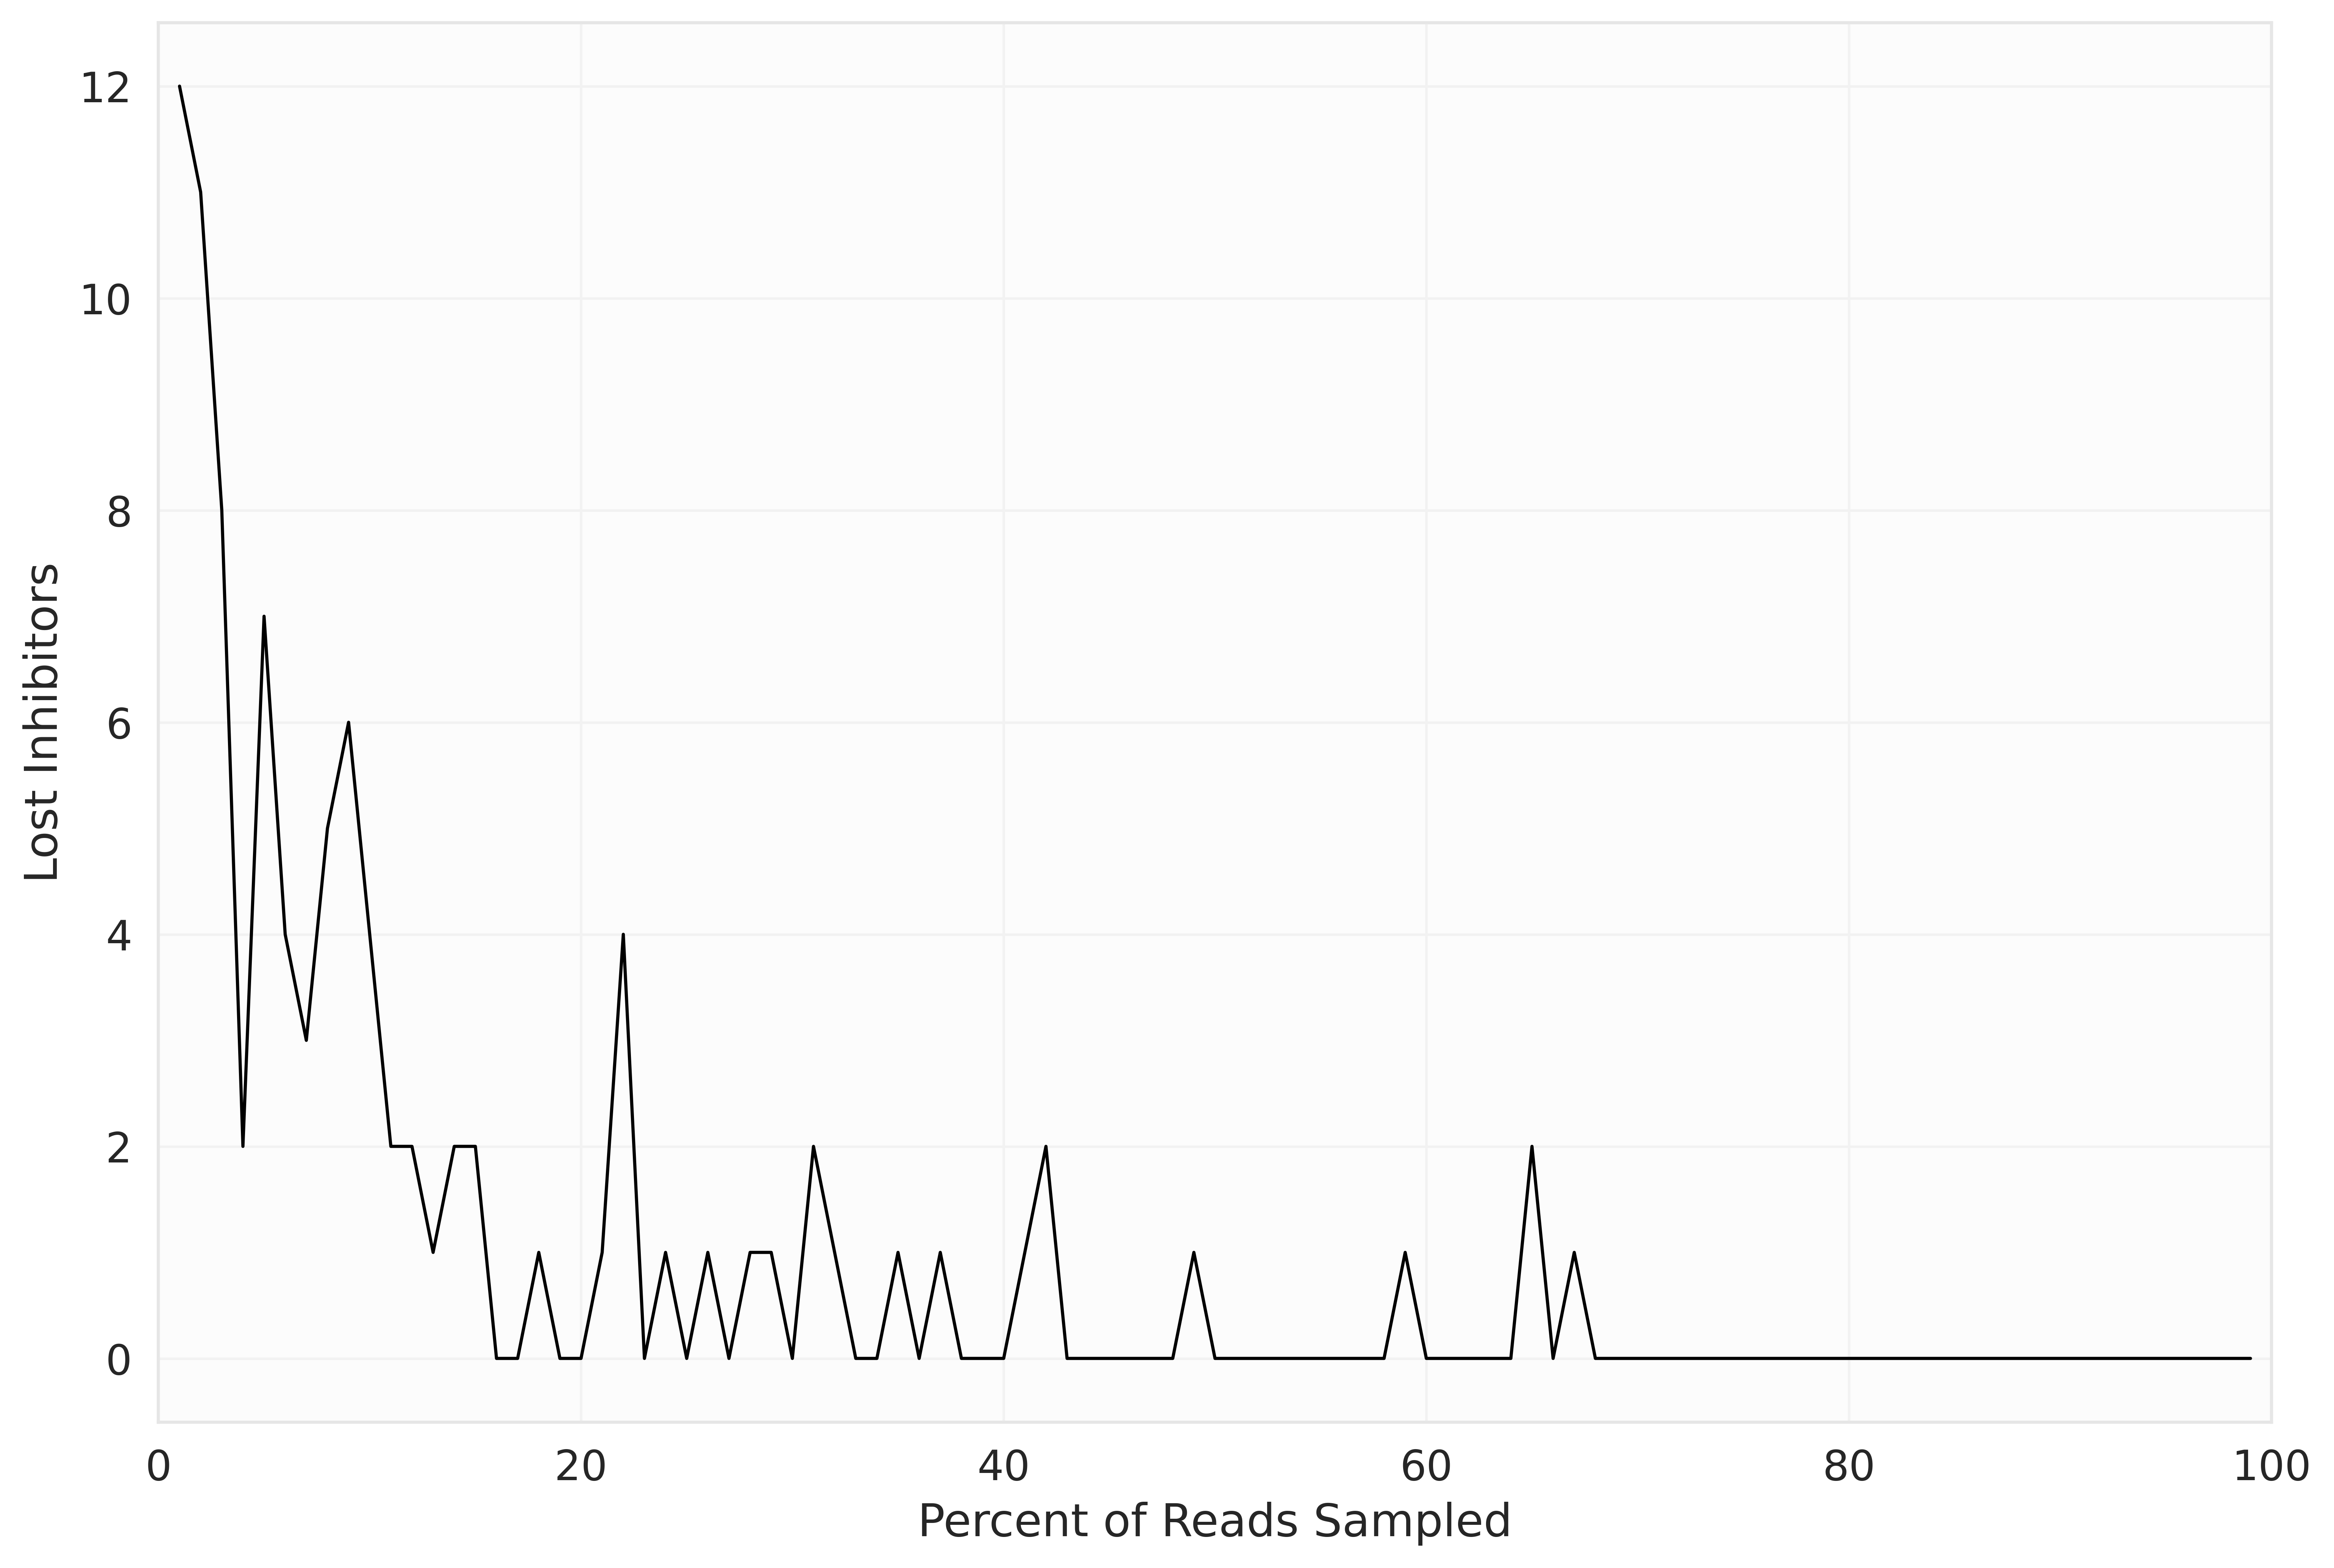

In [9]:
with sns.axes_style(style=style, rc=rc):

    plt.figure(figsize=(12,8), dpi=600)
    sns.lineplot(
        data  = pvaldf,
        x     = "keepfrac",
        y     = "hitloss",
        color = "black",
        lw    = 1)
    plt.xlim([0,100])
    plt.xlabel("Percent of Reads Sampled")
    plt.ylabel("Lost Inhibitors")